# 06 Transfert Learning with PyTorch

What is Transfer Learning?

Transfer learning is a powerful technique in machine learning where knowledge gained from solving one problem is applied to a different but related problem.  Instead of starting the training process from scratch, you leverage a pre-trained model that has already learned useful features from a large dataset. This pre-trained model serves as a starting point, and you fine-tune it on your specific task, which typically requires less data and computational resources than training a model from scratch.

Here's a breakdown of the key concepts:

**1. Pre-trained Model:** This is a model that has been trained on a massive dataset, usually for a general task like image classification (e.g., ImageNet).  These models have learned a rich set of features that can be useful for other related tasks.

**2. Feature Extraction:**  Pre-trained models are excellent feature extractors.  The early layers of the model learn general features (like edges, textures), while later layers learn more specific features (like shapes, objects).  You can use a pre-trained model to extract these features from your data without retraining the entire model.

**3. Fine-tuning:**  This involves taking a pre-trained model and adapting it to your specific task. You typically replace the final layer(s) of the pre-trained model with layers suited for your task (e.g., a new classification layer with the correct number of classes). Then, you train the modified model on your dataset.  You can choose to freeze the weights of the early layers (to preserve the general features) and only train the later layers, or you can train the entire model with a lower learning rate.

**4. When to Use Transfer Learning:**

* **Limited Data:**  Transfer learning is especially beneficial when you have a small dataset for your target task.  Training a complex model from scratch on limited data often leads to overfitting.
* **Computational Constraints:** Fine-tuning a pre-trained model is much faster and requires fewer resources than training from scratch.
* **Improved Performance:**  Transfer learning can often lead to significantly better performance, especially when the source and target tasks are closely related.

**Example:**

Imagine you want to build an image classifier to identify different types of flowers. You have a small dataset of flower images. Instead of training a CNN from scratch, you can use a pre-trained model like ResNet, which has been trained on ImageNet (a massive dataset of general images). You remove ResNet's final classification layer (which classifies ImageNet categories) and replace it with a new classification layer with the number of flower types you want to classify. Then, you fine-tune the modified ResNet on your flower image dataset. The pre-trained features learned by ResNet on ImageNet will help the model learn to classify flowers more efficiently and accurately.

**Key Benefits:**

* Faster training
* Reduced data requirements
* Improved performance (often)
* Easier prototyping

Transfer learning is a widely used and highly effective technique in deep learning, allowing you to leverage the power of large pre-trained models to solve a wide range of problems.


In [2]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)

2.4.1+cu121
0.19.1+cu121


In [3]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision.transforms import v2 as transforms

# Try to get torchinfo, install it if it doen't work
try:
    from torchinfo import summary
except:
    print("torchinfo not found, installing it")
    %pip install torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, if it doesn't work, clone the repo
try:
    from going_modular import data_setup, engine
except:
    print("going_modular not found, cloning the repo")


/media/etudiant/New D/PyTorchSRC/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 1. Get data

we need pizza, steak, sushi data to build our tranfert model

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_dir = Path("data/")
image_dir = data_dir / "images"
zip_path = data_dir / "pizza_steak_sushi.zip"


# Download the data
url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
if not data_dir.exists():
    print("Downloading the data")
    # Ensure the data directory exists
    data_dir.mkdir(parents=True, exist_ok=True)
    response = requests.get(url)
    zip_path.write_bytes(response.content)
else:
    print("Data already downloaded")

# Unzip the data
if zip_path.exists():
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print("Unzipping the data")
        zip_ref.extractall(data_dir)
        
        # remove the zip file
        os.remove(zip_path)
else:
    print("Data already unzipped")



Data already downloaded
Data already unzipped


In [6]:
# Setup the data
train_dir = data_dir / "train"
test_dir = data_dir / "test"

train_dir, test_dir

(PosixPath('data/train'), PosixPath('data/test'))

## 2. Create Datasets and Dataloaders

Now we've got some data, we want to turn it into a form our model can use.

To do this, we'll use the `torchvision.datasets.ImageFolder` class. This class assumes the images are in the following structure:
    
    ```
    root/train/class1/xxx.png
    root/train/class2/xxy.png
    root/train/class3/xxz.png

    root/test/class1/123.png
    root/test/class2/nsdf3.png
    root/test/class3/asd932_.png
    ```

### 2.1 Creating a transform for `torchvision.models` models

In [7]:
from going_modular import data_setup

from torchvision.transforms import v2 as transforms

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225])

manual_transform = transforms.Compose([
                                        transforms.Resize((224, 224)), 
                                        transforms.ToDtype(torch.float32, scale=True),
                                        normalize,
                                        transforms.ToImage()])

In [9]:
train_data, test_data, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                   test_dir=test_dir,
                                                                   transform=manual_transform,
                                                                   batch_size=32)

In [10]:
train_data, test_data, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7307c8935f70>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models`

As of `torchvision` 0.10.0, the `torchvision.models` module has been updated to accept a `transform_input` parameter. This parameter allows you to pass in a function to transform the input data before it's passed through the model.

This is particularly useful when you're using a model which was trained on a different dataset to the one you're using. For example, the `torchvision.models` models were trained on the ImageNet dataset, which has different normalization values to the ones we're using for our pizza_steak_sushi dataset.



In [11]:
import torchvision
torchvision.__version__

'0.19.1+cu121'

In [12]:
# Get a set of pretrained models weights
weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
weights

EfficientNet_B3_Weights.IMAGENET1K_V1

In [13]:
# Get the transforms used to create our pretrained model
pretrained_transform = weights.transforms()
pretrained_transform

ImageClassification(
    crop_size=[300]
    resize_size=[320]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [14]:
# Create DataLoader with pretrained model transforms
train_data, test_data, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                   test_dir=test_dir,
                                                                   transform=pretrained_transform,
                                                                   batch_size=32)

train_data, test_data, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7307b3b47260>,
 ['pizza', 'steak', 'sushi'])


## 3. Getting a pretrained model

There are various pretrained models available in torchvision. We can use them to train our model on our data.

Let's get a pretrained model and see how it performs on our data.

We will use the `torchvision.models` module to get a pretrained model.

The `torchvision.models` module contains a number of popular pretrained models such as:
- AlexNet
- VGG
- ResNet
- SqueezeNet
- DenseNet
- EfficientNet

### 3.1 Which pretrained model to use?

*Experiment, experiment, experiment!*

The whole point of transfer learning is to experiment with different pretrained models and see which one works best for your problem.

Thee things to consider when choosing a pretrained model:
1. speed - how long it takes to train, evaluate and make predictions
2. size - how big the model is (in terms of parameters)
3. performance - how well it does on your specific problem (this is the most important)

### 3.2 Create a pretrained model

In [49]:
model = torchvision.models.efficientnet_b3(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [50]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1)

In [51]:
model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=1000, bias=True)
)

### 3.3 Getting a summary of the model with `torchinfo.summary()`

In [52]:
# Print with torchinfo
from torchinfo import summary

# view the model summary
summary(model, 
        input_size=(1, 3, 224, 224), 
        depth=4,
        col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Kernel Shape              Output Shape              Param #                   Mult-Adds
EfficientNet (EfficientNet)                                  --                        [1, 1000]                 --                        --
├─Sequential (features)                                      --                        [1, 1536, 7, 7]           --                        --
│    └─Conv2dNormActivation (0)                              --                        [1, 40, 112, 112]         --                        --
│    │    └─Conv2d (0)                                       [3, 3]                    [1, 40, 112, 112]         1,080                     13,547,520
│    │    └─BatchNorm2d (1)                                  --                        [1, 40, 112, 112]         80                        80
│    │    └─SiLU (2)                                         --                        [1, 40, 112, 112]         --                  

In [53]:
# # visualize the model
# from torchviz import make_dot

# x = torch.randn(32, 3, 224, 224)
# y = model(x)
# make_dot(y, params=dict(model.named_parameters()))

### 3.4 Freezing the model weights and changing the output layer to fit our needs

In [54]:
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [67]:
# Update the classifier
from torch import nn

model.classifier = nn.Sequential(
    nn.Dropout(0.3, inplace=True),
    nn.Linear(in_features=1536, 
              out_features=len(class_names))
).to(device)

model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1536, out_features=3, bias=True)
)

In [66]:
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [68]:
summary(model,
        input_size=(1, 3, 224, 224), 
        depth=4,
        col_names=["kernel_size", "output_size", "num_params", "mult_adds"],
        row_settings=["var_names"])

Layer (type (var_name))                                      Kernel Shape              Output Shape              Param #                   Mult-Adds
EfficientNet (EfficientNet)                                  --                        [1, 3]                    --                        --
├─Sequential (features)                                      --                        [1, 1536, 7, 7]           --                        --
│    └─Conv2dNormActivation (0)                              --                        [1, 40, 112, 112]         --                        --
│    │    └─Conv2d (0)                                       [3, 3]                    [1, 40, 112, 112]         (1,080)                   13,547,520
│    │    └─BatchNorm2d (1)                                  --                        [1, 40, 112, 112]         (80)                      80
│    │    └─SiLU (2)                                         --                        [1, 40, 112, 112]         --                  

## 4. Train the model

In [70]:
# Define the loss and optimizer functions
from torch import nn, optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [74]:
# Import train function
from going_modular import engine

# Start timer for training
import time
start_time = time.time()

# Train the model
history = engine.train(model=model,
                       train_dataloader=train_data,
                       test_dataloader=test_data,
                       loss_fn=loss_function,
                       optimizer=optimizer,
                       device=device,
                       epochs=5)

# End timer for training
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

 20%|██        | 1/5 [00:20<01:23, 20.89s/it]

Epoch: 1 | train_loss: 0.5860 | train_acc: 0.9219 | test_loss: 0.6138 | test_acc: 0.9176


 40%|████      | 2/5 [00:42<01:03, 21.17s/it]

Epoch: 2 | train_loss: 0.6116 | train_acc: 0.7930 | test_loss: 0.5637 | test_acc: 0.8968


 60%|██████    | 3/5 [01:03<00:41, 20.98s/it]

Epoch: 3 | train_loss: 0.5768 | train_acc: 0.7695 | test_loss: 0.4982 | test_acc: 0.9176


 80%|████████  | 4/5 [01:24<00:21, 21.04s/it]

Epoch: 4 | train_loss: 0.5348 | train_acc: 0.7969 | test_loss: 0.4976 | test_acc: 0.8873


100%|██████████| 5/5 [01:45<00:00, 21.06s/it]

Epoch: 5 | train_loss: 0.5287 | train_acc: 0.7891 | test_loss: 0.4816 | test_acc: 0.8977
Training time: 105.29736495018005


## 5. Evaluate the model by plotting the training history

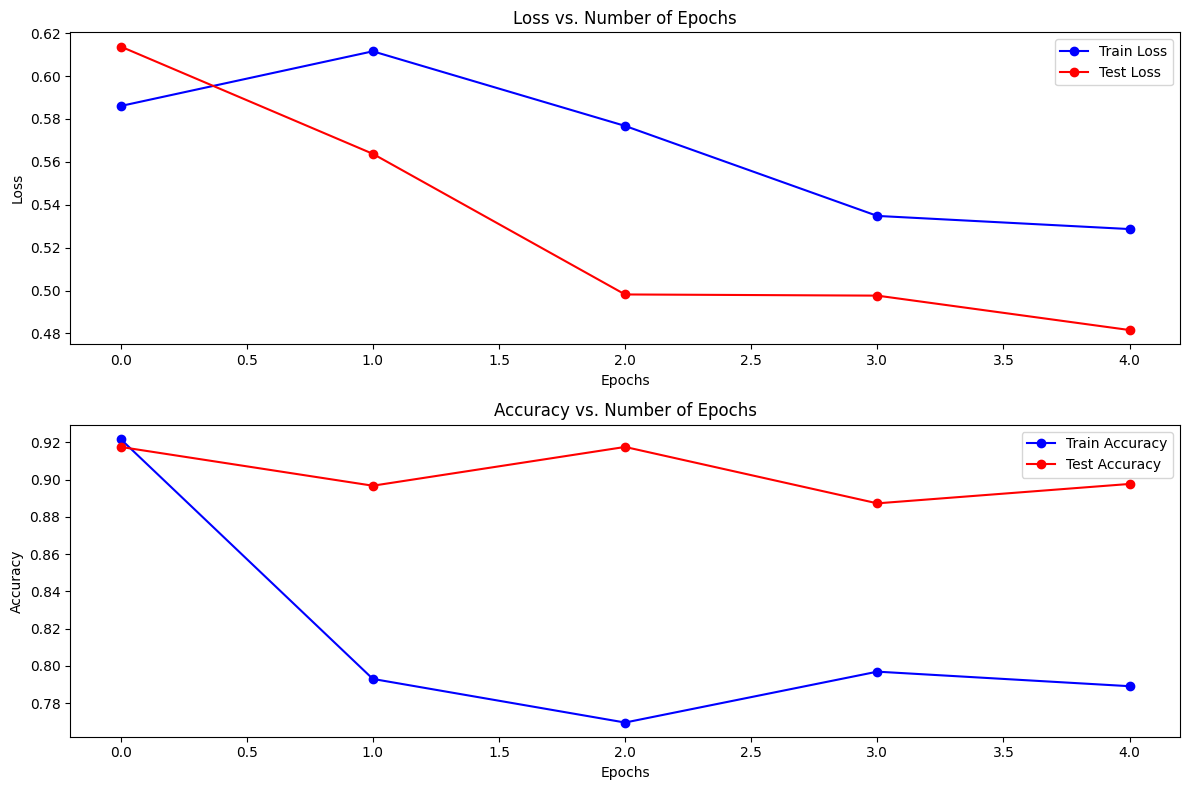

In [88]:
# Plot the training history

from going_modular import plot_results

plot_results.plot_results(history)

## 6. Make prediction with the trained model on test data

In [95]:
from going_modular.predict_image import predict_image

In [100]:
class_names_predicted, probability = predict_image(model=model,
                                                   image_path="data/images/pizza.jpg",
                                                   transform=pretrained_transform,
                                                   class_names=class_names)

In [101]:
class_names_predicted, probability

('pizza', 0.7010912299156189)

In [102]:
class_names_predicted, probability = predict_image(model=model,
                                                   image_path="data/images/steak.jpg",
                                                   transform=pretrained_transform,
                                                   class_names=class_names)

class_names_predicted, probability

('steak', 0.5864909887313843)

In [103]:
class_names_predicted, probability = predict_image(model=model,
                                                   image_path="data/images/sushi.jpg",
                                                   transform=pretrained_transform,
                                                   class_names=class_names)

class_names_predicted, probability

('sushi', 0.6224969029426575)